In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity
import time

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.corpora.dictionary import Dictionary
# from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

**Environment issue**:
* On 6/11/2021 upgrading transformers messed up the environment (topics). Recreated using req.txt (called topics-env).
* Imp point to note - for umap, hdbcsan to work, numba>-0.50.x Added this to the req.txt
* transformers library version = 4.3.2 -- add this during deployment if going with topic summarization
* Not deleting topics environment, in case other working library versions need to be consulted 

In [2]:
from src.util import (c_tf_idf, 
                 extract_top_n_words_per_topic,
                 extract_topic_sizes,
                 topic_cos_sim_metrics)

In [3]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

In [4]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

In [12]:
results_path = '/home/jupyter/bi-topic-modeling/results/' 
SEED = 42

### --- Input data ---

In [5]:
df = pd.read_csv(data_path + 'processed/train_apr25_over100pvs_processed.csv')

print("Shape:", df.shape)
print("Unique tiers:", len(df.tier1.unique()))

Shape: (3334, 10)
Unique tiers: 31


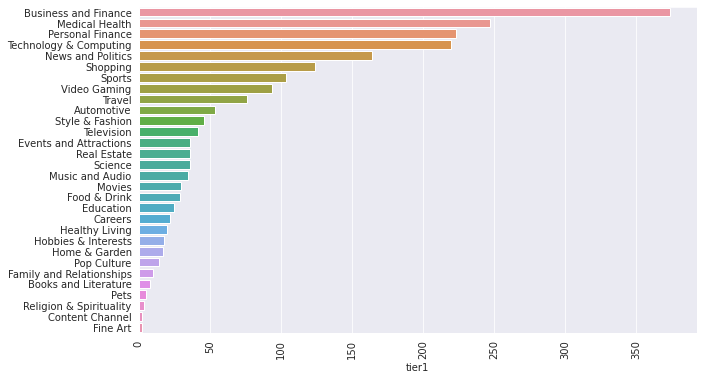

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x=df.tier1.value_counts(), y=df.tier1.value_counts().index)
plt.xticks(rotation=90)
plt.show()

* Per verdict from EDA, will be excluding articles less than 100 words

In [7]:
df["article_length"] = df.clean_body.str.split().apply(len)
df = df[df["article_length"]>=100]

df.tier1 = df.tier1.fillna('Other')
print("Shape", df.shape)
df = df.reset_index(drop=True)

Shape (3327, 11)


### --- Modeling ---

* Function format below

992
article_embeddings len: 992


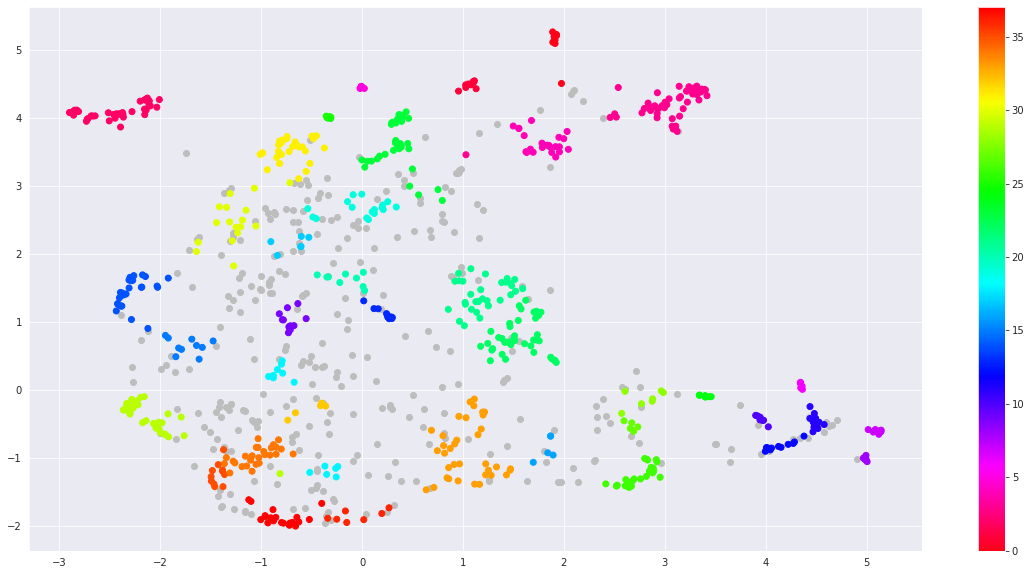

In [19]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

data = df.clean_body.tolist()
print(len(data))

docs_df, top_n_words, topic_sizes = algo(data) # 11.46

**Generate embeddings**

In [8]:
data = df.clean_body.tolist()
print(len(data))

3327


In [9]:
article_embeddings = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")

In [14]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

start = time.time()

# orig
# n_neighbors=15, n_components=5, random_state=SEED,
            
umap_embeddings =  umap.UMAP(
                             n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED
                            ).fit(article_embeddings) 

print('UMAP Took {} minutes to run'.format(round((time.time() - start) / 60, 2)))

# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      min_samples = 4, #new
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

UMAP Took 0.31 minutes to run


In [16]:
# 3327 articles compressed to 2 components

print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (3327, 2)


In [18]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.3751787653262967

In [19]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 173



,Doc,Topic,Doc_ID
0,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the pa...",38,0
1,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list ...",38,1
2,these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do...,14,2
3,these 10 cozy down alternative comforters make your bed feel extra luxurious. your bed should be your safe...,14,3
4,"the wnba turns 25. what will viewership trends mean for the future?. twenty-five years ago, the national b...",160,4
...,...,...,...
3322,friends do not let friends become chinese billionaires. update: chinese nationals are not the only ones ge...,108,3322
3323,how do you change an organizational culture?. changing an organizations culture is one of the most difficu...,111,3323
3324,"three ways to keep those secret purchases secret. not everything in life is meant to be aired in public, a...",68,3324
3325,alexander the great: gay or straight?. (one in a series of conversations between historians james romm and...,55,3325


In [21]:
start = time.time()

# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

print('Took {} minutes to run'.format(round((time.time() - start) / 60, 2)))

Took 0.39 minutes to run


In [22]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

top_n_words_df["topic_words"] = clean_keys

keyword time 0.0003060380617777506


In [19]:
cossim_matrix_df = pd.DataFrame()
topic_num_list = []

for topic_num in sorted(docs_df.Topic.unique()):
    
    topic_group = docs_df[docs_df.Topic== topic_num]
    # grab all articles of given topic
    group_embeddings = [article_embeddings[i] for i in list(topic_group.index)]
    
    # generate cosine similarity metrics for each topic
    metrics_df = topic_cos_sim_metrics(group_embeddings)
    
    # append all topic metrics together
    cossim_matrix_df = cossim_matrix_df.append(metrics_df)

    # make a topic numbers' list
    topic_num_list.append(topic_num)
    
cossim_matrix_df["topic_num"] = topic_num_list

cols = ['topic_num', 'cos_min', 'cos_mean']

cossim_matrix_df = cossim_matrix_df[cols].reset_index(drop=True)

In [20]:
tier_metric = docs_df.join(df[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

In [21]:
topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                                        topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               cossim_matrix_df, on = "topic_num", how="inner"), 
                      iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)
topic_info.tail()

,topic_num,top_20_words,Size,cos_min,cos_mean,distinct_tier1s
106,105,"pomodoro, tasks, productive, task, wrist, time management, crystals, productivity, pomodoro technique, technique, pomodoro sessions, selenite, half work, wrist pain, sessions, habits, crystal, focused work, emails, quartz",8,0.84,0.90,4
107,106,"genuine, servant, genuine people, humble people, executive presence, humble, leaders, leader, leadership, decisions, purpose, grit, body language, clarity, gestures, skills, ve, communication, don, conversation",28,0.78,0.90,4
108,107,"thoughts, disabled, emotions, negative, stress, disabled people, overthinking, brain, ableism, emotional, thinking, negative thoughts, psychotic, negative people, mental, feelings, strong people, self, mentally strong, empathy",23,0.75,0.91,3
109,108,"wendy, leadership, xanax, failure, patriarchy, mcintyre, men, haters, peggy, gonna, regrets, ing, feminine, leader, anxiety, men women, intimacy, davis, started taking, wanted",9,0.83,0.91,3
110,109,"shoulds, lett, sign, berman, emails, recipient, email, small talk, lett likes, person, toxic culture, fear, don, dating, regards, geisler, introverts, interviewer, reader, conversation",12,0.83,0.91,4


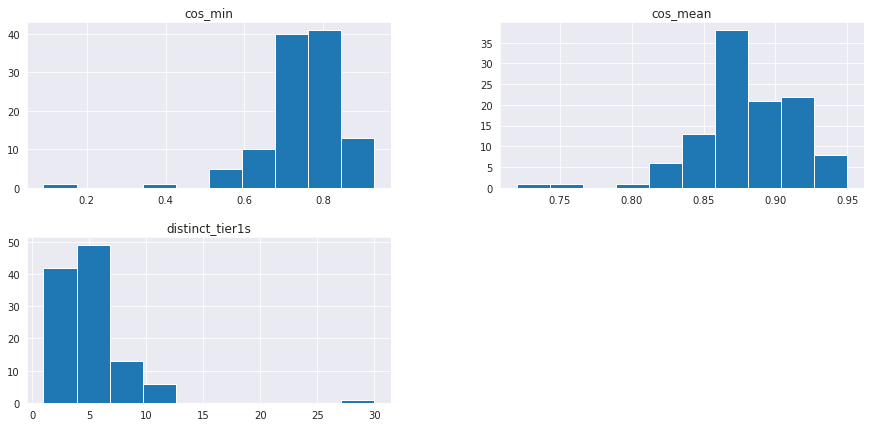

In [22]:
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
plt.show()

* **Re-group/Merge topics**

In [37]:
# whats getting updated - docs_df, top_n_words

for i in range(1):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df) # 7 mins for 20 iters. 10 iter - 4mins

In [38]:
docs_per_topic

,Topic,Doc
0,-1,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the past year at home, forced to stare at the same worn-in couch, threadbare arm chair and sparse wall art. so if youre feeling like its time for ..."
1,0,"ingenuity, nasas mars helicopter, flies faster and further than ever before (photos). topline the third trip for ingenuity, the helicopter nasa sent to mars to study the surface of earths neighboring planet, was a record-breaking expedition, mark..."
2,1,"heres how much money industrial engineers earn in every u.s. state. becoming an industrial engineer is an increasingly popular career route for americans. according to the bureau of labor statistics (bls) occupational outlook handbook , employmen..."
3,2,"17 mothers day sales to shop now through may 9. if you havent gotten a gift for mom yet, dont panic. mothers day, which lands on may 9 this year, is still a little over two weeks away, so you have more than enough time to order one online. a litt..."
4,3,"ufc 261 full-fight video: watch jorge masvidal knock out donald cerrone. donald cerrones stint as a welterweight began as well as anyone could have imagined. after losing a fight to then-lightweight champion rafael dos anjos in december 2015, cer..."
...,...,...
95,94,"spring cleaning for presentation skills. by jen jamula as days grow longer and the sun reveals dust in corners, stains on favorite shirts, and a startling vitamin d deficiency, the annual wave of spring cleaning begins. the impulse is to swiffer,..."
96,95,"want big results? think small. which would you rather have, one big breakthrough or many small breakthroughs? the biggest breakthroughs are noticed. consider the big innovations that rocked the world, starting with fire. other revolutionary ideas..."
97,96,"you are not lazy; you are scared: how to finally stop procrastinating. be honest: do you struggle in getting things started (or completed)? do you tell yourself, ill get to it, yet find yourself binge-watching an entire season of bridgeton instea..."
98,97,"red velvet singer wendy on going solo: i had to believe myself. a little over a year ago, k-pop superstar wendy, better known for her work with the south korean girl group red velvet, had a terrible accident. while rehearsing on stage, the perfor..."


In [42]:
# # UPDATED DOCS_DF
# print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
# print()
# docs_df

In [41]:
# # COSINE SIMILARITY
# cossim_matrix_df = pd.DataFrame()
# topic_num_list = []

# for topic_num in sorted(docs_df.Topic.unique()):
    
#     topic_group = docs_df[docs_df.Topic== topic_num]
#     # grab all articles of given topic
#     group_embeddings = [article_embeddings[i] for i in list(topic_group.index)]
    
#     # generate cosine similarity metrics for each topic
#     metrics_df = topic_cos_sim_metrics(group_embeddings)
    
#     # append all topic metrics together
#     cossim_matrix_df = cossim_matrix_df.append(metrics_df)

#     # make a topic numbers' list
#     topic_num_list.append(topic_num)
    
# cossim_matrix_df["topic_num"] = topic_num_list

# cols = ['topic_num', 'cos_min', 'cos_mean']

# cossim_matrix_df = cossim_matrix_df[cols].reset_index(drop=True)

# tier_metric = docs_df.join(df[["tier1"]])
# tier_metric.tail()

# tier_ct_df = pd.DataFrame(tier_metric.groupby(['Topic']).tier1.value_counts()).rename(columns={'tier1': 
#                                                                                                'tier1_count'
#                                                                                               }).reset_index()
# iab_metric = tier_ct_df.groupby("Topic").agg({"tier1": 'nunique'}).round(2).reset_index().rename(columns = 
#                                                                                                         {'tier1': 
#                                                                                                          'distinct_tier1s',
#                                                                                                          'Topic':
#                                                                                                          'topic_num'})

# topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
#                                         topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
#                                cossim_matrix_df, on = "topic_num", how="inner"), 
#                       iab_metric, on = "topic_num", how="inner")

# topic_info.drop('Topic', axis=1, inplace=True)
# topic_info.tail()

In [35]:
# topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
# plt.show()

**SOFT CLUSTERING**

In [ ]:
# do it on apr 26 - may 2 data (refer 8.data-product-poc)
soft_points = hdbscan.all_points_membership_vectors(cluster)

# training dataset
print(len(soft_points))
print(len(soft_points[0]))

In [ ]:
may3pred_softpoints = hdbscan.membership_vector(cluster, umap_embeddings_may03)

In [ ]:
# pred dataset
print(len(may3pred_softpoints))
print(len(may3pred_softpoints[4198]))

In [ ]:
# The probability that point i is a member of cluster j is in membership_vectors[i, j].
may3pred_softpoints[4198,1]

In [ ]:
print(np.argmax(may3pred_softpoints[4198]))
may3pred_softpoints[4198,158]

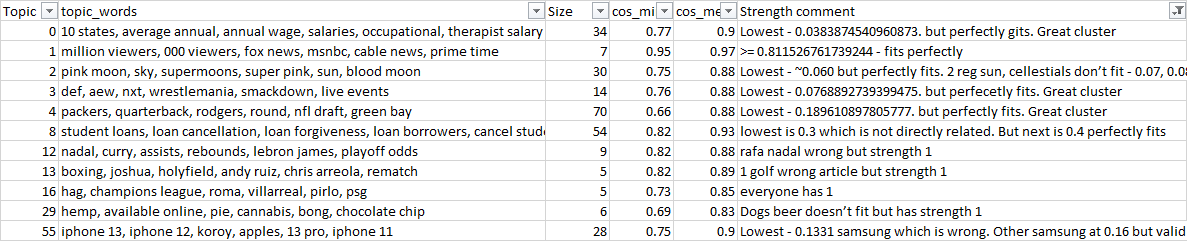

### Topic Naming
* **Check if a topic can be described by a summary of short length.** 
    * Summary taken from all articles belonging to a topic

In [1]:
import pandas as pd
from transformers import pipeline

### Abstractive summary
>generate new sentences from original text.
>>The approach is to identify the important sections, interpret the context and reproduce in a new way. Pre-trained model used = t5 which is trained on summarization tasks

In [2]:
# summarizer = pipeline("summarization") # bart-large-cnn model on pytorch

summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base")

In [3]:
input_df = pd.read_csv("./results/apr26_may02_full_train_topics.csv")

In [17]:
test1 = input_df[input_df.Topic==0]
print(test1.shape)
# print(test1.top_20_words[2268])
print("10 states, average annual, annual wage, salaries, occupational,")

(34, 9)
10 states, average annual, annual wage, salaries, occupational,


* take a sample of 5 articles to generate summary

In [7]:
# test1_txt = test1.Doc.str.cat(sep =" ") # 34 documents - crapped out, said buy more RAM

test1_txt = test1.Doc[:5].str.cat(sep =" ")
len(test1_txt) 

25859

In [12]:
start = time.time()

summary_text = summarizer(test1_txt, min_length=5, do_sample=False)[0]['summary_text']
print(summary_text)

print()
print("elapsed:", round((time.time() - start)/60))

the average annual wage for architects in the u.s. is $89,560 . this is more than double the national average annual salary for all occupations . the top 10 highest-paying states for commercial pilots are california, wyoming, arkansas and tennessee .

elapsed: 1


In [13]:
# take only headings
test2_txt = test1.Doc.apply(lambda x: x.split(".")[0]).str.cat(sep =". ")
len(test2_txt)
test2_txt

'how much money architects make in every state, updated for 2020. heres how much money massage therapists make in every state. heres how much money industrial engineers earn in every u. heres how much money pilots earn in every state. heres how much money high school teachers earn in every state. heres how much money elementary school teachers earn in every state. heres how much money audiologists make in every state. heres how much money detectives make in every state. heres how much money paramedics earn in every state. heres how much money police officers earn in every state. here is how much money anesthesiologists make in every state. heres how much money pharmacy technicians make in every state. heres how much money pediatricians earn in every state. heres how much money respiratory therapists make in every state. heres how much money podiatrists make in every state. heres how much money dental assistants make in every state. heres how much money electrical engineers make in ever

In [14]:
start = time.time()

summary_text = summarizer(test2_txt,  min_length=5, do_sample=False)[0]['summary_text']
print(summary_text)

print()
print("elapsed:", (time.time() - start)/60)

audiologists make in every state, dental assistants make in each state . psychologists, optometrists, pharmacists make all the money in the u.s. updated for 2020: here's how much money architects make in america .

elapsed: 0.045192535718282065


### Extractive summary trials
> recognize important sentences and create a summary using those exact sentences.

In [15]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser

In [16]:
parser=PlaintextParser.from_string(test1_txt,Tokenizer('english'))

lsa_summarizer=LsaSummarizer()
lsa_summary= lsa_summarizer(parser.document,1)

# Printing the summary
for sentence in lsa_summary:
    print(sentence)

the average annual wage for high school teachers in 2014 was $63,400, before rising by 21.5% and reaching $77,050 where it currently stands.


   * chernobyls reactor meltdown formed earths most dangerous lava.
        * thorium, lava, uranium, reactor, volcanoes, eruption, eruptions, volcano, co2, reactors, nuclear, corium, tons co2, tons, radioactive, active volcanoes, mauna, million tons, loa, mauna loa
        * solar, green hydrogen, coal, copper, renewable energy, wind, electricity, neste, emissions, reactor, gas, minerals, repository, fossil fuels, climate, lopez obrador, lava, renewables, oil, synthetic fuels


**Topics contained in Busi and Finance tier are:**
* RELEVANT
    * 64 crypto + elon --all crpto mixed
    * 95 world billionaires 
    * 68 crypto money
    * 76 blockchain 
    * 94 billionaire families 
    * 41 weapons 
    * 17 world news (putin, texas gov, meghan) 
    * 77 taxes 
    * 81 mining? 
    * 100 remote work 
    * 106 analytics for businesses 
    * 98 venture investing?
    * 70 bitcoin loss
    * ev
    * trading stocks
    * 9 alcohol/weed/coffee busi
    * 18 renewable energy
    * workplace
    * 59 covid economy
    * leadership
    * shareholders
    * workplace -ism
    * influencer business
    * prohibited products
    * real estate
    * 1 article:
        * earnings (box office)
        * kodak? (tesla crash)
        * sportscar
        * 54 big chain stores (ecommerce)
        * 97 digital space
        * 101 supply chain
        * 21 latest tech (crypto)
        * 96 workplace health
        * 102 jobs (business negotiations)
        * 32 apple products
        * 73 investment (crypto)
        * 57 real estate
        * 62 student loan (smb covid grants)
        
    
* IRRELEVANT
    * Noise
    * 107 latest tech
    * 44 jnj 
    * 82 ? 
    * 66 ?
    * occupation salaries
    * climate
    * side hustle
    * games - outrisers, hawkmoon?
    * nasa expedition
    * 1 article:
        * 108 speaker? (effective listening)
        * 29 hacking? (GA)
        * 39 vaccine (novavax)
        * 56 songs billboard (taylor)
        * 5 passport travel
        * 42 flight
        * 3 meals
        * 65 ? (meghan markle)
        * 53 cancel culture